In [1]:
# Writeup for the solution: https://docs.google.com/document/d/18WvZjXNb6uousWPijxhgJu3tzbyaiOc5TfK5Sedw51Y/edit
import math
from collections import Counter

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import AerSimulator

import pandas as pd
from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.circuit.library import GroverOperator, ZGate
from qiskit.algorithms import AmplificationProblem

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.algorithms import Grover
from qiskit import Aer
from qiskit.compiler import transpile, assemble

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def apply_h_on_address_by_key(quantum_registers, search_key):
    for reg in qregs:
        if search_key in reg.name:
            c.h(reg)

In [3]:
# Localization and grid-handling code

# def index_to_coordinate(idx, width):
#     # height (top down, zero indexed)
#     # width (left to right, zero indexed)
#     return int(idx / width), idx % width

# def is_path_dependency(top_buffer

In [4]:
# Functions for a generalized form of Dicke State Preparation
# This will allow us to generate all possible permutations of the sequence [R,R,R,D,D,D]
# which are all the possible shortest paths of the maze.

def targeted_ry(circuit, indices, params):
    for idx in range(len(indices)):
        circuit.ry(params[idx], indices[idx])
    return circuit

def targeted_cnot(circuit, index_pairs):
    for target, control in index_pairs:
        circuit.cnot(control, target)
    return circuit

def divide():
    circuit = QuantumCircuit(6)
    circuit = targeted_ry(circuit, [0, 2, 4], \
                          [2*np.arccos(np.sqrt(1/20)), \
                           np.arccos(np.sqrt(10/19)), \
                           np.arccos(np.sqrt(1/10))])
    
    circuit = targeted_cnot(circuit, [(1, 0), (2, 1)])
    circuit.ry(-np.arccos(np.sqrt(10/19)), 2)
    circuit = targeted_cnot(circuit, [(3, 2), (4, 3)])
    circuit.ry(-np.arccos(np.sqrt(1/10)), 4)
    circuit.cnot(4, 5)
    
    circuit = targeted_cnot(circuit, [(2, 1), (1, 2), (2, 1)])
    circuit = targeted_cnot(circuit, [(4, 3), (3, 4), (4, 3)])
    circuit = targeted_cnot(circuit, [(3, 2), (2, 3), (3, 2)])
    
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    
    return circuit

def conquer():
    circuit = QuantumCircuit(6)
    circuit = targeted_ry(circuit, [1, 4], \
                          [np.pi / 2, np.pi / 2])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 2, 3, 4], \
                          [np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-np.pi / 2, -np.pi / 2])
    
    circuit = targeted_cnot(circuit, [(0, 1), (5, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-0.5*np.arccos(np.sqrt(2/3)), \
                           -0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 2), (4, 3)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [0.5*np.arccos(np.sqrt(2/3)), \
                           0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 0), (4, 5)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-0.5*np.arccos(np.sqrt(2/3)), \
                           -0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 2), (4, 3)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [0.5*np.arccos(np.sqrt(2/3)), \
                           0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(0, 1), (5, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [np.pi / 2, np.pi / 2])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 2, 3, 4], \
                          [np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2))])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-np.pi / 2, -np.pi / 2])
    
    return circuit

In [6]:
def add(circuit, num_bits, qreg1, qreg2):
    draper_circ = DraperQFTAdder(num_bits)
    return circuit.compose(draper_circ, list(qreg1) + list(qreg2))

def to_bin(val, num_bits):
    bin_val = bin(val)[2:]
    # do some padding
    bin_val = "0"*(num_bits-len(bin_val))+bin_val
    return bin_val

def set_values(qc, num_bits, val, ctrl, qreg):
    bin_val = to_bin(val, num_bits)
    for j, bin_digit in enumerate(bin_val):
        if bin_digit == "1":
            qc.cx(ctrl,qreg[num_bits-j-1])
    return qc

# add 1 if dir_qubit = |R>, n if dir_qubit = |D>
def add_based_on_dir_qubit(num_bits, n):
    idx_offset_qreg = QuantumRegister(num_bits, "idx_offset")
    curr_idx_qreg = QuantumRegister(num_bits, "curr_idx")
    dir_q = QuantumRegister(1)
    qc = QuantumCircuit(idx_offset_qreg, curr_idx_qreg, dir_q)
                            
    qc.cx(dir_q, idx_offset_qreg[0], ctrl_state=0) # R just sets it to 1
    qc = set_values(qc, num_bits, n, dir_q, idx_offset_qreg) # D just sets it to n
        
    qc = add(qc, num_bits, idx_offset_qreg, curr_idx_qreg)
    
    # now we should unset
    qc = set_values(qc, num_bits, n, dir_q, idx_offset_qreg) # D just sets it to n
    qc.cx(dir_q, idx_offset_qreg[0], ctrl_state=0) # R just sets it to 1

    return qc

def path_set_based_on_current_index(num_bits, n):
    curr_idx_qreg = QuantumRegister(num_bits, "curr_idx")
    path_grid_qreg = QuantumRegister(n*n, "grid")
    qc = QuantumCircuit(curr_idx_qreg, path_grid_qreg)

    for i in range(1, n*n):
        bin_val = to_bin(i, num_bits)
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "0":
                qc.x(curr_idx_qreg[num_bits-j-1])
        qc.mcx(curr_idx_qreg, path_grid_qreg[i])
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "0":
                qc.x(curr_idx_qreg[num_bits-j-1])
    return qc

def path_unset(num_bits, n, curr_idx_qreg, path_grid_qreg, qc):
    for i in range(1, n*n):
        bin_val = to_bin(i, num_bits)
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "1":
                qc.cx(path_grid_qreg[i], curr_idx_qreg[num_bits-j-1])
    qc.barrier()

                
n = 4
# we subtract by 1 because 4=100, doesnt exist we just need 0,1,2,3
num_bits = len(bin(n*n - 1)) - 2
idx_offset_qreg = QuantumRegister(num_bits, "idx_offset")
curr_idx_qreg = QuantumRegister(num_bits, "curr_idx")
path_grid_qreg = QuantumRegister(n*n, "grid")
dir_seq_qreg = QuantumRegister(2*n-2, "dir_seq")
extra_grid_qreg = QuantumRegister(2, "extra_grid")
# note we will reuse the first 4 registers for the maze qubits
qregs = [dir_seq_qreg, idx_offset_qreg, curr_idx_qreg, extra_grid_qreg, path_grid_qreg]

idx_offset_creg = ClassicalRegister(num_bits, "midx_offset")
curr_idx_creg = ClassicalRegister(num_bits, "mcurr_idx")
dir_seq_creg = ClassicalRegister(2*n-2, "mdir_seq")
# cregs = [dir_seq_creg, idx_offset_creg, curr_idx_creg]
cregs = [ClassicalRegister(n*n, "m_path_grid"), ClassicalRegister(n*n, "m_maze_grid"), ClassicalRegister(n*n, "m_maze_grid_2")]
qc = QuantumCircuit(*qregs, *cregs)
divide_gate = divide().to_gate()
divide_gate.label = "divide"
qc.append(divide_gate, list(dir_seq_qreg))
conquer_gate = conquer().to_gate()
conquer_gate.label = "conquer"
qc.append(conquer_gate, list(dir_seq_qreg))
qc.x(path_grid_qreg[0]) # always set to 1

for dir_q in dir_seq_qreg:
    # based on input direction, change the index offset
    # R (i.e ctrl_state=0): should +1
    # D (i.e ctrl_state=1): should +n
    # [idx_offset_qreg, curr_idx_qreg, dir_q]
    add_gate = add_based_on_dir_qubit(num_bits, n).to_gate()
    add_gate.label = "add"
    qc.append(add_gate, list(idx_offset_qreg)+list(curr_idx_qreg)+[dir_q])

    # path_set_based_on_current_index(num_bits, n, curr_idx_qreg, path_grid_qreg, qc)
    path_set_gate = path_set_based_on_current_index(num_bits, n).to_gate()
    path_set_gate.label = "path_set_gate"
    qc.append(path_set_gate, list(curr_idx_qreg) + list(path_grid_qreg))

qc.barrier()
qc.measure(range(16), range(32,32+16))
# reset so we can re-use, we don't care if the state collapses,
#. we are going to measure 1 state at the end anyways
qc.reset(range(16))

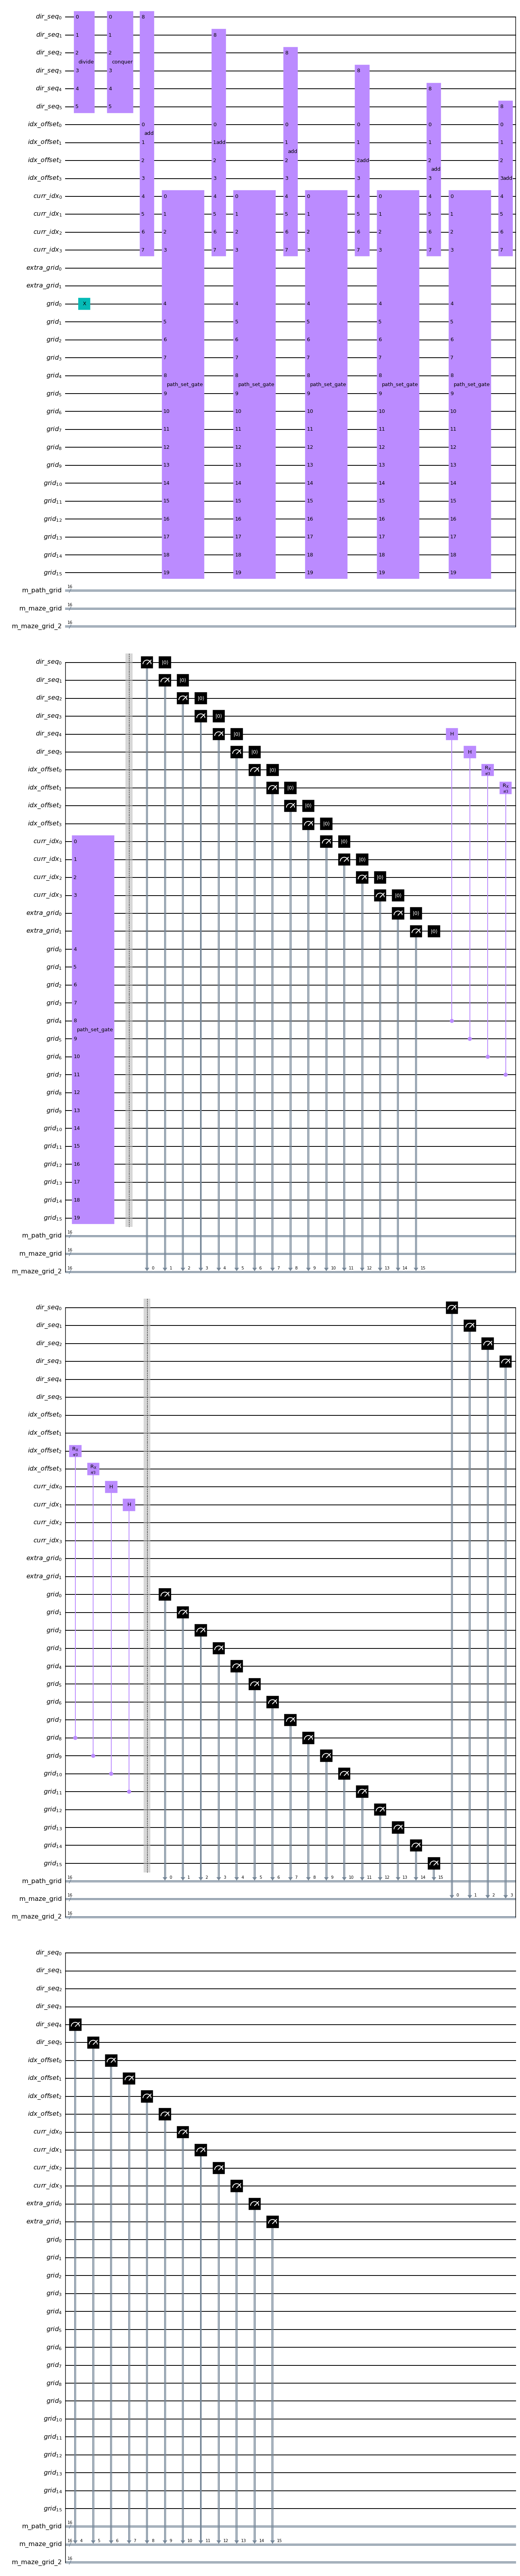

In [7]:
maze = [0,0,0,0, 0.5,0.5,0.75,0.75, 0.75,0.75,0.5,0.5, 0,0,0,0]

# set the maze based on the paths
for i in range(len(maze)):
    if maze[i] == 0:
        pass
    elif maze[i] == 0.5:
        qc.ch(i + 16, i)
    elif maze[i] == 1:
        qc.cx(i + 16, i)
    else:
        qc.crx(2*math.acos(math.sqrt(maze[i])), i + 16, i)
qc.barrier()
qc.measure(range(16, 32),range(0, 16)) # measure path here
qc.measure(range(0, 16),range(16, 32)) # measure maze here

qc.draw('mpl')

In [15]:
backend = provider.backends.ibmq_qasm_simulator
shots = 1000
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

most_common = Counter(answer).most_common()
most_common = [c for c in most_common if '1' not in c[0].split(' ')[0]] # make sure no 1's in maze (second part of measurement)
print(most_common)

Simulation failed and returned the following error message:
ERROR: a circuit requires more memory than max_memory_mb.


Result(backend_name='aer_simulator_extended_stabilizer', backend_version='0.10.4', qobj_id='470fd31e-edda-44dc-b943-72e2b8a91e1f', job_id='0d95fb29-2e0e-480c-ba34-f67144de0d08', success=False, results=[ExperimentResult(shots=0, success=False, meas_level=2, data=ExperimentResultData(), status=EMPTY, seed_simulator=0, metadata={}, time_taken=0.0)], date=2022-05-18T19:58:20.477626, status=ERROR: a circuit requires more memory than max_memory_mb., status=QobjHeader(backend_name='aer_simulator_extended_stabilizer', backend_version='0.10.4'), metadata={'mpi_rank': 0, 'time_taken': 0.024548842, 'max_gpu_memory_mb': 0, 'max_memory_mb': 0, 'time_taken_load_qobj': 0.023938524, 'parallel_experiments': 1, 'num_mpi_processes': 1, 'omp_enabled': True}, time_taken=0.02613997459411621)


In [ ]:
output = [(x[0].split(' ')[1],x[1]) for x in most_common]
print(output)
pd_list = []
prob_total = 0

for path, count in output:
    probability_clear = 1
    for location, prob_failure in list(zip(path, maze)):
        if location == '1':
            probability_clear = probability_clear * (1 - prob_failure)
    prob_total += probability_clear

for path, count in output:
    result_dict = dict()
    probability_clear = 1
    for location, prob_failure in list(zip(path, maze)):
        if location == '1':
            probability_clear = probability_clear * (1 - prob_failure)
    
    result_dict['path'] = path
    result_dict['prob'] = probability_clear / prob_total
    result_dict['prob_quantum'] = 20 * count / shots
    pd_list.append(result_dict)

print(pd.DataFrame(pd_list))